In [55]:
import pandas as pd
import numpy as np
import networkx as nx
import json
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [118]:
# Load data
package_feats = json.load(open('./dataset/package-features.json'))
project_data = json.load(open("./GithubScrape/Data/60_topics_JS/append_dependencies_40_7.json"))

In [119]:
print(len(project_data.keys()))

456


In [121]:
# For each project remove dependencies that are not available
def clean_project_data(data, valid):
    for project, deps in data.items():
        data[project] = [p for p in deps.keys() if p in valid]
        
clean_project_data(project_data, package_feats.keys())

In [17]:
def create_package_list(data):
    packages = set()
    for deps in data.values():
        packages.update(deps)
    return list(packages)

18868


In [86]:
def create_ground_truth_matrix(data):
    package_list = create_package_list(project_data)
    package_list.sort()
    project_names = sorted(data.keys())
    
    gt_mat = np.full((len(project_names), len(package_list)), -1)
    
    for i, project in enumerate(project_names):
        for pkg in data[project]:
            if pkg in package_list:
                j = package_list.index(pkg)
                gt_mat[i, j] = 1
                    
    return gt_mat, package_list, project_names
                
ground_truth, package_order, project_order = create_ground_truth_matrix(project_data)

In [87]:
print(ground_truth.shape)

(238, 18868)


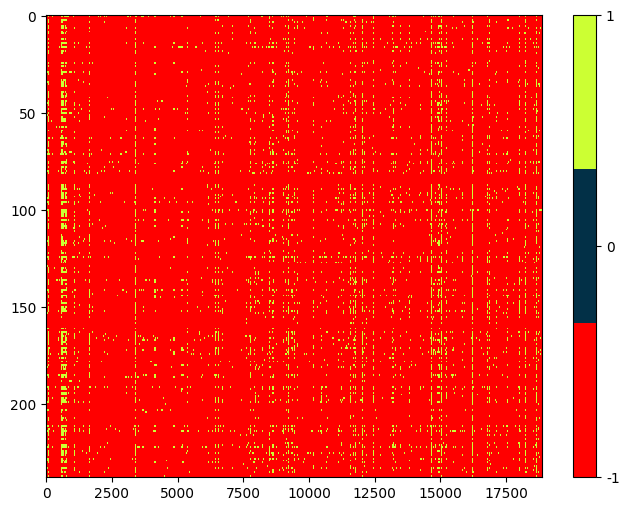

In [88]:
def visualize_matrix(mat, colors=('red', '#023047', '#ccff33')):
    cmap = ListedColormap(colors)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(mat, cmap=cmap, interpolation='nearest', aspect='auto')
    
    cbar = plt.colorbar(ticks=[-1, 0, 1])
    cbar.ax.set_yticklabels(['-1', '0', '1'])
    
    plt.show()
    
visualize_matrix(ground_truth)

In [89]:
np.random.seed(42)  # For reproducibility

# Function to mask a percentage of values
def mask_matrix(matrix, mask_percentage):
    masked_matrix = matrix.copy()
    total_elements = matrix.size
    num_to_mask = int(total_elements * mask_percentage / 100)
    
    # Get random indices to mask
    indices = np.random.choice(total_elements, num_to_mask, replace=False)
    rows, cols = np.unravel_index(indices, matrix.shape)
    
    # Mask selected values
    masked_matrix[rows, cols] = 0  # Replace with 0 (or np.nan if preferred)
    return masked_matrix

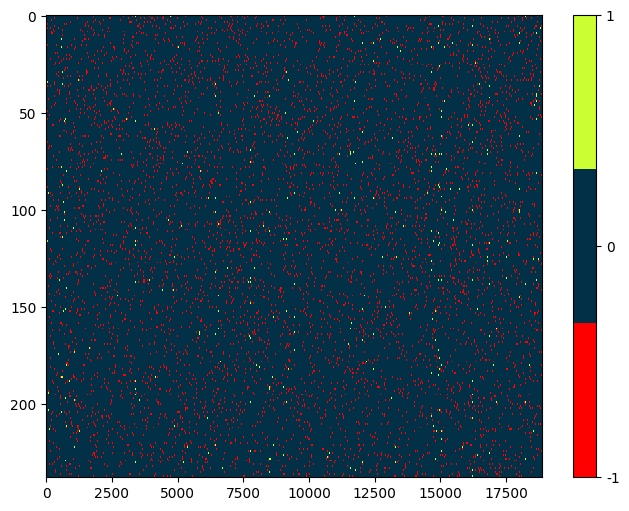

In [90]:
training_matrix = mask_matrix(ground_truth, 95)
visualize_matrix(training_matrix)

In [91]:
from IPython.display import clear_output

def collaborative_filtering(M, O, Otest, Mgt, lambdaNuc_factor=4, lambdaDF=1e1, max_iter=2000, tol=1e-1):
    # Initialization
    n, m = M.shape
    OM = O * M
    normOM = np.linalg.norm(OM, 2)
    lambdaNuc = normOM / lambdaNuc_factor
    
    # Identify zero rows and columns
    idx_zero_cols = np.where(np.sum(O, axis=0) < 1e-9)[0]
    idx_zero_rows = np.where(np.sum(O, axis=1) < 1e-9)[0]
    nb_zero_cols = len(idx_zero_cols)
    nb_zero_rows = len(idx_zero_rows)
    
    X = M.copy()
    Xb = X.copy()
    Y = np.zeros_like(M)
    normA = 1.0
    sigma = 1.0 / normA
    tau = 1.0 / normA
    diffX = 1e10
    min_nm = np.min([n, m])
    k = 0

    def shrink(S, thresh):
        return np.maximum(S - thresh, 0) - np.maximum(-S - thresh, 0)
    
    # Iterative process
    while k < max_iter and diffX > tol:
        k += 1
        
        # Update dual variable Y
        Y = Y + sigma * Xb
        U, S, V = np.linalg.svd(Y / sigma, full_matrices=False)
        Sdiag = shrink(S, lambdaNuc / sigma)
        Sshrink = np.zeros_like(M)
        for i in range(len(Sdiag)):
            Sshrink[i, i] = Sdiag[i]
        Y = Y - sigma * (U @ np.diag(Sdiag) @ V)
        
        # Update primal variable X
        Xold = X.copy()
        X = X - tau * Y
        X = (X + tau * lambdaDF * O * M) / (1 + tau * lambdaDF * O)
        
        # Fix issues with rows/columns with no observations
        r, c = np.where(X > 0.0)
        median = np.median(X[r, c]) if len(r) > 0 else 0
        if nb_zero_cols > 0:
            X[:, idx_zero_cols] = median
        if nb_zero_rows > 0:
            X[idx_zero_rows, :] = median
        
        # Update primal variable Xb
        Xb = 2 * X - Xold
        
        # Difference between iterations
        diffX = np.linalg.norm(X - Xold)
        
        # Reconstruction error
        err_test = np.sqrt(np.sum((Otest * (X - Mgt))**2)) / np.sum(Otest) * (n * m)
        
        # Visualization
        if not k % 50:
            clear_output(wait=True)
            # plt.figure(figsize=(8, 6))
            # plt.imshow(X, interpolation='nearest', cmap='jet')
            # plt.title(f'Collaborative Filtering\nIteration={k}\nReconstruction Error={round(err_test, 5)}')
            # plt.colorbar()
            # plt.show()
            visualize_matrix(X)
            print(f'diffX: {diffX}')
    
    return X
    

In [116]:
M = ground_truth
mask_percentage = 95
O = np.random.choice([0, 1], size=M.shape, p=[mask_percentage / 100, (100 - mask_percentage) / 100])
training_matrix = O * M

reconstructed_matrix = collaborative_filtering(
    M=M,
    O=O,
    Otest=O,  # Use the same mask for testing in this case
    Mgt=M,
    lambdaNuc_factor=10,
    lambdaDF=1e1,
    max_iter=10,
    tol=1e-1
)

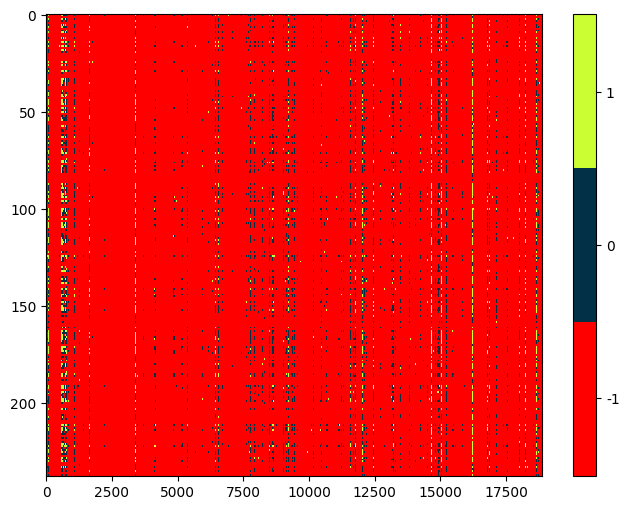

In [117]:
visualize_matrix(reconstructed_matrix)

In [112]:
def reconstruction_error(original, test):
    
    # Apply the mask to calculate the error only on specified elements
    difference = original - test
    squared_error = np.square(difference)
    mean_squared_error = np.mean(squared_error)
    rmse = np.sqrt(mean_squared_error)
    
    return rmse


In [113]:
reconstruction_error(ground_truth, reconstructed_matrix)

0.28901956488640046